# Introduction: Active Learning Cycle

This notebook encompasses the comprehensive workflow of the active learning cycle, designed to iteratively improve the predictive accuracy of our model by intelligently selecting new data points for training. The cycle consists of the following steps:

1. Load the Cleaned Data: Import the pre-processed and cleaned data set ready for integration and analysis.

2. Integrate All Obtained Data: Combine data from various sources into a unified dataset for model training.

3. Save the Integrated Data: Persist the integrated dataset to disk for reproducibility and future reference.

4. Train a Predictive Model: Utilize the integrated data to train a machine learning model capable of predicting target variables with high accuracy.

5. Save the Predictive Model: Save the trained model to ensure that it can be reused without retraining.

6. Create a Grid in the Feature Space: Generate a comprehensive grid that spans the entire feature space under consideration.

7. Extract a Subset of the Grid that is Experimentally Feasible: Identify and isolate parts of the grid that are viable for experimental verification based on predefined criteria.

8. Predict the Target Value in the Subset: Use the trained model to predict target values for the experimentally feasible subset.

9. Save the Predicted Properties of the Subset: Store the predictions to guide future experimental endeavors.

10. Acquire Data Based on Predicted Properties: Select new data points for acquisition based on the model's predictions and a tiered acquisition strategy, aiming to maximize the model's learning.


11. Save the Acquired Data: Document the newly acquired data points to refine the model in subsequent learning cycles.

By following this structured approach, we aim to efficiently navigate the feature space, prioritize experimental efforts, and iteratively refine our model's predictive capability. This cycle is pivotal in harnessing the potential of active learning to address complex problems with an evolving data-driven strategy.

# Libraries



In [2]:
%matplotlib widget

import numpy as np 
import pandas as pd
from datetime import datetime
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import random
import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm, neighbors
from sklearn.svm import SVR
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import plotly.express as px

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os 
import inspect
import sys

script_path = inspect.getframeinfo(inspect.currentframe()).filename
script_dir = os.path.dirname(os.path.abspath(script_path))
sys.path.append(script_dir)

import lithium_brine_ml as lbml

# Functions

In [4]:
def load_from_dict(data_dict_address):
    '''This function loads dataframes from excel files and returns a dictionary of dataframes.
    
    Parameters:
    ----------
    data_dict_address: dictionary of addresses of excel files
        dictionary
        
    Returns:
    -------
    data_dict: dictionary of dataframes
        dictionary'''
        
    data_dict = {}
    
    # load dataframes from excel files:
    
    for key in data_dict_address.keys():
        
        data_dict[key] = pd.read_excel(data_dict_address[key])
        
    return data_dict


def dataframe_format_correction(data_dict, label1, label2):
    '''
    This function changes the column names/labels to the same format for all dataframes.
    
    Parameters:
    ----------
    data_dict: dictionary of dataframes
        dictionary of pd.DataFrame
        
    label1: list of old column names
        list
        
    label2: list of new column names
        list
        
    Returns:
    -------
    data_corrected_labels: dictionary of dataframes with corrected labels
        dictionary of pd.DataFrame'''
    
    data_corrected_labels = {}
    
    # for each dataframe in the dictionary:
    # change the column names/labels to the same format for all dataframes
    # label1 list of old column names and label2 list of new column names
    
    for key in data_dict.keys():
        
        data_corrected_labels[key] = data_dict[key].rename(columns=dict(zip(label1, label2)))
    
    return data_corrected_labels


def basic_clean(data_dict, eps=0.01):
    '''
    This function cleans the dataframes by removing NaN values and replacing 0 values with eps.
    
    Parameters:
    ----------
    data_dict: dictionary of dataframes
        dictionary of pd.DataFrame
    
    eps: small number to replace 0 values
        float
    
    Returns:
    -------
    data_cleaned: dictionary of cleaned dataframes
        dictionary of pd.DataFrame
    '''
    data_cleaned = {}
    
    for key in data_dict.keys():
        data_cleaned[key] = data_dict[key].dropna()
        data_cleaned[key]['yield'] = data_dict[key]['yield'].apply(lambda x: x+eps if x==0 else x)
        
    return data_cleaned

def data_integration(data_dict):
    ''' 
    This function integrates the dataframes in the dictionary into one dataframe.
    
    Parameter:
    ----------
    data_dict: dictionary of dataframes
        dictionary of pd.DataFrame
    
    Return:
    -------
    data_integrated: integrated dataframe
        pd.DataFrame
    '''
    
    data_integrated = pd.DataFrame()
    
    for key in data_dict.keys():
        data_integrated = pd.concat([data_integrated, data_dict[key]])
    
    data_integrated = data_integrated.reset_index(drop=True)
    
    return data_integrated


def fact_check(combination):
    '''
    Checking if the nominated data (suggested experiment) satisfies acquisition guidlines or not
    
    Parameter:
    ----------
    combination: an array containing the experiment combinations. 
                     The combination of data must follow below order: 
                     [{C} , {N}, {Li}, {T}]
    Returens: 
    ----------
    check: True if all the criteria are satisfied, False if not 
    
    '''
    #print(combination)
    
    c = combination[0]
    n = combination[1]
    l = combination[2]
    
    c_total_limit = 0.5 * n
    
    
    if n > 6:
        return False
    
    if c > c_total_limit:
        return False
    
    if c > 2.5: 
        return False
    
    if l > 6 or l <= 0:
        return False
    
    if c < (l/2):
        return False
    
    #print('n: ', n, ' || n_total: ',n_total, ' || c: ', c, " || c_total_limit: ", c_total_limit, " || Li: ", l)
    return True 

def df_scaler(fit_df, transform_df, labels_list = ['init_C', 'init_N', 'init_Li', 'T']):
    '''
    Recieves two dataframes and scales the second dataframe using the first dataframe
    Parameters:
    ----------
    fit_df: the dataframe to be used for fitting the scaler
        pd.DataFrame
        
    transform_df: the dataframe to be scaled
        pd.DataFrame
        
    labels_list: the list of labels to be used for scaling
        list
    
    Returns:
    ----------
    scaled_df: the scaled dataframe
    
    '''
    
    # using the batch containing all the data scale the experimental grid
    scaler = preprocessing.StandardScaler().fit(fit_df[labels_list])
    scaled_df = scaler.transform(transform_df[labels_list])
    
    return scaled_df

def entropy_measure(std_list):
    '''
    The function is used to calculate the entropy of the standard deviation of the model prediction
    
    Parameters:
    ------------
        std_list: the list of the standard deviation of the model prediction
            list
            
    Returns:
    ------------
        entropy: the entropy of the standard deviation of the model prediction
            float
    '''
    
    std_list = np.array(std_list)
    # entropy = ln(std*root(2*pi*e))
    entropy = np.log(std_list * np.sqrt(2*np.pi*np.e))
    
    return entropy


def binary_model_plot(model, scaler, range_a, range_b, val_c,
                      label_a, label_b , label_c , T = 66,
                      entropy_contour=False, std_contour=True, yield_contour=True):
    '''
    The function is used to plot the binary contour plot of the model prediction

    Parameters:
    ------------
        model: the model to predict the yield
            SKlearn model object
            
        scaler: the scaler used to scale the data
            SKlearn scaler object
            
        range_a: the range of the first parameter
            tuple
            
        range_b: the range of the second parameter
            tuple
            
        val_c: the value of the third parameter
            float
            
        label_a: the label of the first parameter
            string
            
        label_b: the label of the second parameter
            string
            
        label_c: the label of the third parameter
            string
            
        T: the temperature of the experiment
            float
            
        entropy_contour: if True, the entropy contour will be plotted
            bool
            
        std_contour: if True, the standard deviation contour will be plotted
            bool
        
        yield_contour: if True, the yield contour will be plotted
            bool
        
    Returns:
    ------------
    none
        
        '''
    
    a_list = np.linspace(range_a[0], range_a[1], 50)
    b_list = np.linspace(range_b[0], range_b[1], 50)

    a_mesh, b_mesh = np.meshgrid(a_list, b_list)
    yield_mesh = a_mesh.copy()
    std_mesh = a_mesh.copy()
    entropy_mesh = a_mesh.copy()
    
    for i in tqdm(range(len(a_list))):
        for j in range(len(b_list)):
            x_df = pd.DataFrame({label_a: a_mesh[i,j],
                                 label_b : b_mesh[i,j],
                                 label_c : [val_c],
                                 'T':[T]})
            # it is crucial to rearrange the columns in the same order as the training data!!!
            x_df = x_df[['init_C', 'init_N', 'init_Li', 'T']]
            
            scaled_grid = scaler.transform(x_df)
            yield_mesh[i,j], std_mesh[i,j] = model.predict(scaled_grid, return_std=True)
            if entropy_contour:
                entropy_mesh[i,j] = entropy_measure(std_mesh[i,j])
            
    plt.figure()
    
    plt.contourf(a_mesh, b_mesh, yield_mesh, 100, cmap = 'viridis')
    cbar = plt.colorbar()
    
    if std_contour:
        contour1 = plt.contour(a_mesh, b_mesh, std_mesh, colors = 'red')
        plt.clabel(contour1, inline=True, fontsize=8)
    
    if yield_contour:
        contour2 = plt.contour(a_mesh, b_mesh, yield_mesh, colors = 'black')
        plt.clabel(contour2, inline=True, fontsize=8)
    
    if entropy_contour:
        contour3 = plt.contour(a_mesh, b_mesh, entropy_mesh, colors = 'blue')
        plt.clabel(contour3, inline=True, fontsize=8)
    
        
    
    plt.xlabel(label_a)
    plt.ylabel(label_b)
    cbar.ax.set_ylabel('Yield')
    plt.title(label_c + ": " + str(val_c))
    plt.show()
    plt.tight_layout()
    
    return


def model_scaler_setup(model, train_df, labels_list = ['init_C', 'init_N', 'init_Li', 'T'], target = 'yield'):
    '''
    This function takes in a model, training data, and the labels and target of the training data and returns the trained model and scaler.
    
    Parameters:
    ----------
    model: sklearn model
    
    train_df: pandas dataframe
    
    labels_list: list of strings
    
    target: string
    
    Returns:
    -------
    model: fitted sklearn model 
    
    scaler: fitted sklearn scaler
    
    '''
    # Define the scaler 
    scaler = preprocessing.StandardScaler().fit(train_df[labels_list])
    scaled_batch = scaler.transform(train_df[labels_list])
    
    # train the model on scaled data
    model.fit(scaled_batch, train_df[target])
    
    return model, scaler

# Create a grid for the prediction space:

def create_exp_grid(label_a = "init_C", label_b = "init_N", label_c = "init_Li", label_d= "T",
                    range_a = (0,2.5), range_b = (0,6), range_c = (0,6), range_d = (66,66)
                    ):
    '''
    This function creates a grid of experimental conditions for the model to predict.
    
    Parameters:
    ----------
    label_a: string
    
    label_b: string
    
    label_c: string
    
    label_d: string
    
    range_a: tuple
    
    range_b: tuple
    
    range_c: tuple
    
    range_d: tuple
    
    Returns:
    -------
    exp_grid: pandas dataframe
    
    '''
    
    exp_grid = pd.DataFrame({label_a:[], label_b : [], label_c : [], label_d: []})
    
    for a in tqdm(np.linspace(range_a[0], range_a[1], 16)):
        for b in np.linspace(range_b[0],range_b[1],37):
            for c in np.linspace(range_c[0],range_c[1],37):
                for d in np.linspace(range_d[0],range_d[1],1):
                    x_df = pd.DataFrame({label_a:[a],
                                         label_b : [b],
                                         label_c : [c],
                                         label_d: [d]})
                    exp_grid = exp_grid.append(x_df)
    
    return exp_grid
    
    
def grid_feasibility(data_df, label_a = "init_C", label_b = "init_N", label_c = "init_Li", label_d= "T"):
    '''This function takes in a dataframe of experimental conditions and returns a list of booleans indicating whether the conditions are feasible or not.
    Parameters:
    ----------
    data_df: pandas dataframe
    
    label_a: string
    
    label_b: string
    
    label_c: string
    
    label_d: string
    
    Returns:
    -------
    data_df: pandas dataframe'''    
    fact_check_list = []
    
    for i in tqdm(range(len(data_df))):
        fact_check_list.append(fact_check([data_df[label_a][i],
                                           data_df[label_b][i],
                                           data_df[label_c][i],
                                           data_df[label_d][i]]))
    
    data_df['fact_check'] = fact_check_list
    
    return data_df


def scale_dataframe(exp_grid, train_df, labels_list = ['init_C', 'init_N', 'init_Li', 'T']):
    '''This function takes in a dataframe of experimental conditions and returns the scaled dataframe.
    Parameters:
    ----------
    exp_grid: pandas dataframe
    
    train_df: pandas dataframe
    
    labels_list: list of strings
    
    Returns:
    -------
    exp_grid: pandas dataframe with scaled columns'''
    
    # Define the scaler 
    scaler = preprocessing.StandardScaler().fit(train_df[labels_list])
    scaled_batch = scaler.transform(train_df[labels_list])
    
    # scale the experimental grid
    scaled_exp_grid = scaler.transform(exp_grid[labels_list])
    
    exp_grid['scl_'+labels_list[0]] = scaled_exp_grid[:,0]
    exp_grid['scl_'+labels_list[1]] = scaled_exp_grid[:,1]
    exp_grid['scl_'+labels_list[2]] = scaled_exp_grid[:,2]
    exp_grid['scl_'+labels_list[3]] = scaled_exp_grid[:,3]
    
    return exp_grid



def euclidean_distance(input_batch, vector, n_components = 3):
    '''
    Finds the minimum euclidean distance between a batch of vector (batch, np.arrays) and a new vector (experiment, np.array)
    
    Parameters:
    -----------
    input_batch: 2D np array (a set of vectors)
    vector: 1D np array (a vector)
    
    Returne:
    -----------
    min_distance: minimum Euclidean distance of the vector to the batch 
    
    '''
    
    batch_np = np.array(input_batch)
    vector_np = np.array(vector)
    

    dislocation = batch_np[0, 0:n_components] - vector_np[0:n_components]
    min_distance = np.linalg.norm(dislocation)

    for i in range(len(batch_np)):
        dislocation = batch_np[i,0:n_components] - vector_np[0:n_components]
        distance = np.linalg.norm(dislocation)
        
        if min_distance > distance:
            min_distance = distance
    
    return min_distance




def tierd_greedy_acquisition(exp_grid_df, train_df, tier1_label = 'std', tier2_label = 'gpr_yield', 
                             tier1_acquisition = 12, tier2_acquisition = 6, tier3_acquisition = 6, min_distance = 0.5):
    """
    data_df: dataframe with columns 'std' and 'gpr_yield'
    tier1_label: column name for the first tier of acquisition
    tier2_label: column name for the second tier of acquisition
    n: number of samples to acquire
    """
    acquisition_batch = []
    control_batch = train_df[['init_C', 'init_N', 'init_Li']].values
    temp_df = exp_grid_df.copy()
    # sort the dataframe by the first tier
    temp_df = temp_df.sort_values(by=tier1_label, ascending=False)
    temp_df.reset_index(drop=True)
    
    acquisition_counter = 0 
    row_counter = 0
    while acquisition_counter < tier1_acquisition:
        if euclidean_distance(control_batch, temp_df.iloc[row_counter, 0:3].values) > min_distance and temp_df.iloc[row_counter]["fact_check"]==True:
            acquisition_batch.append(temp_df.iloc[row_counter])
            control_batch = np.append(control_batch, [temp_df.iloc[row_counter, 0:3]], axis=0)
            acquisition_counter += 1
        
        row_counter += 1
    
    acquisition_counter = 0 
    row_counter = 0
    temp_df = temp_df.sort_values(by=tier2_label, ascending=False)
    temp_df.reset_index(drop=True)
    while acquisition_counter < tier2_acquisition:
        if euclidean_distance(control_batch, temp_df.iloc[row_counter, 0:3].values) > min_distance and temp_df.iloc[row_counter]["fact_check"]==True:
            acquisition_batch.append(temp_df.iloc[row_counter])
            control_batch = np.append(control_batch, [temp_df.iloc[row_counter, 0:3]], axis=0)
            acquisition_counter += 1
        
        row_counter += 1
    
    acquisition_counter = 0 
    while acquisition_counter < tier3_acquisition:
        row_counter = random.randint(0,len(exp_grid_df)-1)
        if euclidean_distance(control_batch, temp_df.iloc[row_counter, 0:3].values) > min_distance and temp_df.iloc[row_counter]["fact_check"]==True:
            acquisition_batch.append(temp_df.iloc[row_counter])
            control_batch = np.append(control_batch, [temp_df.iloc[row_counter, 0:3]], axis=0)
            acquisition_counter += 1
        
    acquisition_df = pd.DataFrame(acquisition_batch, columns = ['init_C', 'init_N', 'init_Li', 'T', 'gpr_yield', 'std', 'fact_check'])
    
    acquisition_type = []
    for i in range(len(acquisition_df)):
        if i < tier1_acquisition:
            acquisition_type.append(tier1_label)
        elif i < tier1_acquisition + tier2_acquisition:
            acquisition_type.append(tier2_label)
        else:
            acquisition_type.append('random')
        
    acquisition_df['acquisition'] = acquisition_type
    
    return acquisition_df
    

def binary_model_plot(model, scaler, range_a, range_b, val_c,
                      label_a, label_b , label_c , T = 66,
                      entropy_contour=False, std_contour=True, yield_contour=True):
    '''
    The function is used to plot the binary contour plot of the model prediction

    Parameters:
    ------------
        model: the model to predict the yield
            SKlearn model object
            
        scaler: the scaler used to scale the data
            SKlearn scaler object
            
        range_a: the range of the first parameter
            tuple
            
        range_b: the range of the second parameter
            tuple
            
        val_c: the value of the third parameter
            float
            
        label_a: the label of the first parameter
            string
            
        label_b: the label of the second parameter
            string
            
        label_c: the label of the third parameter
            string
            
        T: the temperature of the experiment
            float
            
        entropy_contour: if True, the entropy contour will be plotted
            bool
            
        std_contour: if True, the standard deviation contour will be plotted
            bool
        
        yield_contour: if True, the yield contour will be plotted
            bool
        
    Returns:
    ------------
    none
        
        '''
    
    a_list = np.linspace(range_a[0], range_a[1], 50)
    b_list = np.linspace(range_b[0], range_b[1], 50)

    a_mesh, b_mesh = np.meshgrid(a_list, b_list)
    yield_mesh = a_mesh.copy()
    std_mesh = a_mesh.copy()
    entropy_mesh = a_mesh.copy()
    
    for i in tqdm(range(len(a_list))):
        for j in range(len(b_list)):
            x_df = pd.DataFrame({label_a: a_mesh[i,j],
                                 label_b : b_mesh[i,j],
                                 label_c : [val_c],
                                 'T':[T]})
            # it is crucial to rearrange the columns in the same order as the training data!!!
            x_df = x_df[['init_C', 'init_N', 'init_Li', 'T']]
            
            scaled_grid = scaler.transform(x_df)
            yield_mesh[i,j], std_mesh[i,j] = model.predict(scaled_grid, return_std=True)
            if entropy_contour:
                entropy_mesh[i,j] = entropy_measure(std_mesh[i,j])
            
    plt.figure()
    
    plt.contourf(a_mesh, b_mesh, yield_mesh, 100, cmap = 'viridis')
    cbar = plt.colorbar()
    
    if std_contour:
        contour1 = plt.contour(a_mesh, b_mesh, std_mesh, colors = 'red')
        plt.clabel(contour1, inline=True, fontsize=8)
    
    if yield_contour:
        contour2 = plt.contour(a_mesh, b_mesh, yield_mesh, colors = 'black')
        plt.clabel(contour2, inline=True, fontsize=8)
    
    if entropy_contour:
        contour3 = plt.contour(a_mesh, b_mesh, entropy_mesh, colors = 'blue')
        plt.clabel(contour3, inline=True, fontsize=8)
    
        
    
    plt.xlabel(label_a)
    plt.ylabel(label_b)
    cbar.ax.set_ylabel('Yield')
    plt.title(label_c + ": " + str(val_c))
    plt.show()
    plt.tight_layout()
    
    return


# 1- Load the Cleaned Data 

Import the pre-processed and cleaned data set ready for integration and analysis.

In [5]:
import pandas as pd

# Instructions for users:
# Update the file_paths list below with the actual paths to your cleaned data files.
# These paths should point to the Excel files containing the data from each batch you wish to load.
# Ensure the format is correct and consistent with your operating system's path conventions.
# Example format for Windows: "data\\clean\\batch0.xlsx"
# Example format for Unix/Linux: "data/clean/batch0.xlsx"

file_paths = [
    'data/clean/batch0.xlsx',  # Update this path to your first batch file
    'data/clean/batch1.xlsx',  # Update this path to your second batch file
    'data/clean/batch2.xlsx'   # Update this path to your third batch file
    # Add more paths as needed for additional batches
]

# Initialize a list to store the loaded data from each batch
data_batches = []

# Loop through the file paths, loading each file's data into a DataFrame
# and appending it to the data_batches list.
for path in file_paths:
    # Load the Excel file into a DataFrame
    data = pd.read_excel(path)
    # Append the loaded data to the data_batches list
    data_batches.append(data)

# At this point, data_batches contains a list of DataFrames,
# each representing the data from one of the specified files.
# You can now proceed with integrating and analyzing these DataFrames as needed.


# 2- Integrate All Obtained Data


Combine data from various sources into a unified dataset for model training.


In [10]:
# Instructions for users:
# At this point, it's assumed that you have a list of DataFrames named `data_batches`,
# each containing data from different batches as loaded in the previous step.

# To integrate all the obtained data into a single DataFrame for model training,
# we use the pandas concat function. This function effectively merges the list of
# DataFrames into one, stacking them vertically (one on top of the other) by default.

# Integrate all obtained data from the different batches
data = pd.concat(data_batches, ignore_index=True)

# The `ignore_index=True` parameter is used to reindex the new DataFrame. This is useful
# when the original DataFrames have their own indices that might overlap; reindexing
# prevents any potential issues with duplicate indices.

# At this stage, `data` is a unified DataFrame containing all the data from the different batches.
# This integrated dataset is now ready for further processing, such as cleaning, exploration,
# and model training.

## Data inspection: 

In [11]:
data.head()

,Telescope_id,exp_id,init_C,init_N,init_Li,T,fini_Li,yield
0,CS-NRCan-014_A1,B0-0,0.5,4.5,1.0,66,0.720406,0.279594
1,CS-NRCan-014_A2,B0-1,1.0,4.5,1.0,66,0.660309,0.339691
2,CS-NRCan-014_A3,B0-2,1.5,4.5,1.0,66,0.735669,0.264331
3,CS-NRCan-014_A5,B0-3,1.0,6.0,1.0,66,0.621322,0.378678
4,CS-NRCan-014_A6,B0-4,1.5,6.0,1.0,66,0.655983,0.344017


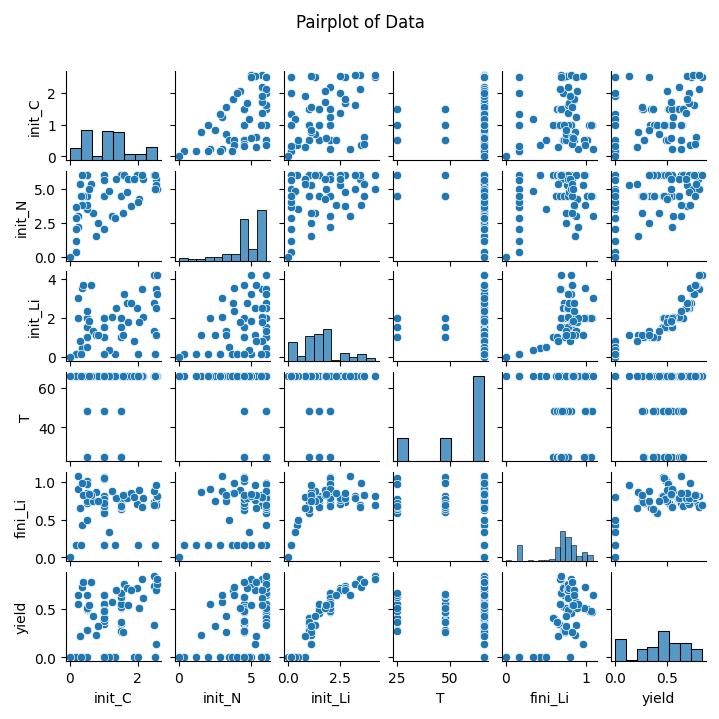

In [16]:
# Assuming 'data' is your DataFrame

# Set the size of each subplot with the 'height' parameter.
# 'aspect' controls the width of each subplot relative to its height; aspect=1 means each plot is square.
pairplot = sns.pairplot(data, height=1.2, aspect=1)

# Adjust overall figure size if necessary
plt.subplots_adjust(top=0.9)
plt.suptitle('Pairplot of Data', fontsize=12)  # Add a title to the figure

# Show the plot
plt.show()

# 3- Save the Integrated Data:

Persist the integrated dataset to disk for reproducibility and future reference.

In [ ]:
import pandas as pd
from datetime import datetime

# Assuming `data` is your integrated DataFrame and you want to save it as 'new_data_integrated'

# Get the current date and time in the format Year-Month-Day_Hour-Minute-Second
# This ensures that each file saved has a unique name based on the exact time it was saved.
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Define the path and filename with the current timestamp
# Adjust the directory path as needed for your project's file organization.
file_path = f'data/clean/new_data_{now}.xlsx'

# Save the DataFrame as an Excel file using the path and filename defined above
# If you're using a Windows system, you might need to use double backslashes (\\) or raw string literals (r'path')
data.to_excel(file_path, index=False)

# Note: The `index=False` parameter is used to prevent pandas from writing row indices into the Excel file.
# If your data's index carries meaningful information, you might want to omit this parameter.

# This command will save your integrated data to the specified path with a timestamp,
# making it easy to identify and access specific versions of your data.


# 4- Train a Predictive Model

Utilize the integrated data to train a machine learning model capable of predicting target variables with high accuracy.

## Feature and target selection

In [22]:
# Selecting the features and the target from the dataset. The features include initial concentrations
# and temperature ('init_C', 'init_N', 'init_Li'), and the target is the yield ('yield').
x_train = data[['init_C', 'init_N', 'init_Li']]
y_train = data['yield']

# Scaling the features to standardize them. This is crucial for models that are sensitive to
# the scale of the input features, such as Gaussian Process Regressors.
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)


## Define the models and hyperparameters tuning

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern, ConstantKernel as C
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# The choice of model and its hyperparameters can significantly affect the prediction performance.
# We use the Gaussian Process Regressor (GPR), a powerful and flexible model for regression problems.

# Defining a grid of hyperparameters allows us to explore a range of model configurations.
# The 'kernel' parameter controls the shape of the process' covariance function,
# and 'alpha' deals with the model's noise level. We'll use GridSearchCV to find the best combination.
param_grid = {
    'kernel': [C(1.0, (1e-2, 1e2)), RBF(1.0, (1e-2, 1e2)),
               RBF(0.5, (1e-2, 1e2)),
               RBF(10.0, (1e-2, 1e2)),
               RBF(100.0, (1e-2, 1e2)),
               Matern(length_scale=0.1),
               Matern(length_scale=0.5),
               Matern(length_scale=1),
               WhiteKernel()],
    'alpha': np.logspace(-5, 2, 8)
}

# GridSearchCV systematically works through multiple combinations of parameter values,
# cross-validates each to determine which configuration gives the best performance.
gpr = GaussianProcessRegressor()

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Performing the grid search on the scaled training data.
grid_search = GridSearchCV(
    gpr, 
    param_grid, 
    cv=5, 
    n_jobs=-1,
    scoring= mae_scorer,
    error_score='raise', # raise an exception if a score cannot be computed
    verbose=2 # print out more detailed error messages
)

# Fit GridSearchCV to the data. This process can be time-consuming for large datasets or complex models
# but is crucial for finding the most accurate model configuration.
grid_search.fit(x_train_scaled, y_train)

# Get the cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['params', 'mean_test_score', 'std_test_score']])
print('='*50)
best_idx = cv_results['mean_test_score'].argmax()
print(f'Best parameters for GPR: {cv_results["params"][best_idx]}')
print('Best score: {}'.format(grid_search.best_score_))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
                                               params  mean_test_score  \
0                    {'alpha': 1e-05, 'kernel': 1**2}        -0.219749   
1     {'alpha': 1e-05, 'kernel': RBF(length_scale=1)}        -0.108052   
2   {'alpha': 1e-05, 'kernel': RBF(length_scale=0.5)}        -0.108052   
3    {'alpha': 1e-05, 'kernel': RBF(length_scale=10)}        -0.187659   
4   {'alpha': 1e-05, 'kernel': RBF(length_scale=100)}        -0.187659   
..                                                ...              ...   
67  {'alpha': 100.0, 'kernel': RBF(length_scale=100)}        -0.315294   
68  {'alpha': 100.0, 'kernel': Matern(length_scale...        -0.422865   
69  {'alpha': 100.0, 'kernel': Matern(length_scale...        -0.315298   
70  {'alpha': 100.0, 'kernel': Matern(length_scale...        -0.315299   
71  {'alpha': 100.0, 'kernel': WhiteKernel(noise_l...        -0.427234   

    std_test_score  
0         0.113909  
1      

Best parameters for different methods are as follows:

- Best parameters for GPR: {'alpha': 0.001, 'kernel': Matern(length_scale=10, nu=1.5)}
- Best score: -0.053484038058140136

- Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
- Best score for Decision Tree: 0.06063882006374226

- Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
- Best score for Random Forest: 0.055737128116578306

- Best parameters for K-Nearest Neighbor: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
- Best score for K-Nearest Neighbor: 0.08994459562199185

## 4.3. Train the models

In [26]:
# After identifying the best parameters, we train a final model using these settings.
# This model is then ready to make predictions on new, unseen data.

#best_kernel = grid_search.best_params_['kernel']
#model = GaussianProcessRegressor(kernel=best_kernel, alpha=grid_search.best_params_['alpha'], n_restarts_optimizer=5)
#model.fit(x_train_scaled, y_train)

#Example:
model = GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=1.5), n_restarts_optimizer=5)
model.fit(x_train_scaled, y_train)

GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=1.5),
                         n_restarts_optimizer=5)

# 5- Save the predictive model

Save the trained model to ensure that it can be reused without retraining.

In [28]:
#import pickle

# Assuming `model` is your trained model object from the previous steps

# Specify the filename for the saved model
#model_filename = 'trained_model.pkl'

# Open a file in write-binary (wb) mode to save the model
#with open(model_filename, 'wb') as file:
#    pickle.dump(model, file)

# The model is now saved to 'trained_model.pkl' and can be loaded later for predictions

# Load the model from the file
#with open(model_filename, 'rb') as file:
#    loaded_model = pickle.load(file)

# `loaded_model` is now the same as the `model` object you saved earlier
# You can use `loaded_model.predict()` to make predictions

# 6- Create a Grid in the Feature Space

Generate a comprehensive grid that spans the entire feature space under consideration.


In [29]:
def create_exp_grid(label_a = "init_C", label_b = "init_N", label_c = "init_Li", label_d= "T",
                    range_a = (0,2.5), range_b = (0,6), range_c = (0,6), range_d = (66,66)
                    ):
    '''
    This function generates a comprehensive grid over the specified feature space.
    
    Parameters:
    ----------
    label_a, label_b, label_c, label_d : str
        The labels of the features for which the grid is created.
    range_a, range_b, range_c, range_d : tuple
        The minimum and maximum values (inclusive) to create the grid for each feature.
    
    Returns:
    -------
    pd.DataFrame
        A DataFrame containing all combinations of the specified feature ranges.
    '''
    
    exp_grid = pd.DataFrame({label_a:[], label_b : [], label_c : [], label_d: []})
    
    for a in tqdm(np.linspace(range_a[0], range_a[1], 16)):
        for b in np.linspace(range_b[0],range_b[1],37):
            for c in np.linspace(range_c[0],range_c[1],37):
                for d in np.linspace(range_d[0],range_d[1],1):
                    x_df = pd.DataFrame({label_a:[a],
                                         label_b : [b],
                                         label_c : [c],
                                         label_d: [d]})
                    exp_grid = exp_grid.append(x_df)
    
    return exp_grid
    

In [30]:
# Example usage of the function to create an experimental grid
# Users should adjust the feature labels and ranges according to their specific datasets
exp_grid = create_exp_grid()
print(exp_grid.head())  # Display the first few rows of the grid


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

   init_C  init_N   init_Li     T
0     0.0     0.0  0.000000  66.0
0     0.0     0.0  0.166667  66.0
0     0.0     0.0  0.333333  66.0
0     0.0     0.0  0.500000  66.0
0     0.0     0.0  0.666667  66.0


In [32]:
def scale_dataframe(exp_grid, train_df, labels_list = ['init_C', 'init_N', 'init_Li']):
    '''This function takes in a dataframe of experimental conditions and returns the scaled dataframe.
    Parameters:
    ----------
    exp_grid: pandas dataframe
    
    train_df: pandas dataframe
    
    labels_list: list of strings
    
    Returns:
    -------
    exp_grid: pandas dataframe with scaled columns'''
    
    # Define the scaler 
    scaler = preprocessing.StandardScaler().fit(train_df[labels_list])
    scaled_batch = scaler.transform(train_df[labels_list])
    
    # scale the experimental grid
    scaled_exp_grid = scaler.transform(exp_grid[labels_list])
    
    exp_grid['scl_'+labels_list[0]] = scaled_exp_grid[:,0]
    exp_grid['scl_'+labels_list[1]] = scaled_exp_grid[:,1]
    exp_grid['scl_'+labels_list[2]] = scaled_exp_grid[:,2]
    
    return exp_grid


In [33]:
# Assuming 'x_train' is your training DataFrame which has already been defined
# Here, we scale the experimental grid based on 'x_train'
exp_grid = scale_dataframe(exp_grid, x_train, ['init_C', 'init_N', 'init_Li'])

# Reset the index for clarity
exp_grid.reset_index(drop=True, inplace=True)
print(exp_grid.head())  # Display the first few rows of the scaled grid

# Note to users:
# Ensure that the training data ('x_train') has been properly prepared before using it to scale the experimental grid.
# The experimental grid now matches the scale of your training data and is ready for predictive modeling.
# Proceed to assess the experimental feasibility of each combination in the grid in the next step.

   init_C  init_N   init_Li     T  scl_init_C  scl_init_N  scl_init_Li
0     0.0     0.0  0.000000  66.0   -1.662726   -3.539546    -1.659431
1     0.0     0.0  0.166667  66.0   -1.662726   -3.539546    -1.484481
2     0.0     0.0  0.333333  66.0   -1.662726   -3.539546    -1.309531
3     0.0     0.0  0.500000  66.0   -1.662726   -3.539546    -1.134581
4     0.0     0.0  0.666667  66.0   -1.662726   -3.539546    -0.959630


# 7- Extract a Subset of the Grid that is Experimentally Feasible

Identify and isolate parts of the grid that are viable for experimental verification based on predefined criteria.

In [38]:
def fact_check(combination):
    '''
    Evaluates if the given combination of experimental conditions meets predefined feasibility criteria.
    
    Parameters:
    ----------
    combination : list
        List containing the experiment combinations in the order: [C, N, Li, T].
    
    Returns:
    -------
    bool
        True if all criteria are satisfied, False otherwise.
    
    The feasibility criteria used here are placeholders. Adjust them based on actual experimental constraints.
    '''
    
    # Extract individual feature values from the combination
    c, n, l = combination[0], combination[1], combination[2]
    
    # Define feasibility criteria based on chemical and experimental guidelines
    c_total_limit = 0.5 * n
    if n > 6 or c > c_total_limit or c > 2.5 or l > 6 or l <= 0 or c < (l / 2):
        return False  # Criteria not met
    return True  # Criteria met

In [39]:
def grid_feasibility(data_df, label_a="init_C", label_b="init_N", label_c="init_Li", label_d="T"):
    '''
    Iterates over a DataFrame of experimental conditions, applying `fact_check` to each row.
    
    Parameters:
    ----------
    data_df : pd.DataFrame
        DataFrame containing experimental conditions.
    label_a, label_b, label_c, label_d : str
        Column labels for the features to check for feasibility.
    
    Returns:
    -------
    pd.DataFrame
        Original DataFrame with an added 'fact_check' column indicating feasibility.
    '''
    
    # List to store feasibility results
    fact_check_list = []
    
    # Check each row for feasibility
    for i in tqdm(data_df.index, desc="Assessing feasibility"):
        combination = [data_df.loc[i, label_a], data_df.loc[i, label_b], data_df.loc[i, label_c], data_df.loc[i, label_d]]
        fact_check_list.append(fact_check(combination))
    
    # Add feasibility results to DataFrame
    data_df['fact_check'] = fact_check_list
    
    return data_df

In [40]:
# Apply the feasibility check to the experimental grid
exp_grid = grid_feasibility(exp_grid)

# Filter the grid for feasible experiments
feasible_exp_grid = exp_grid[exp_grid['fact_check'] == True]

# Display the first few rows of the feasible experimental grid
print(feasible_exp_grid.head())

# Instructions to Users:
# The `feasible_exp_grid` DataFrame now contains only those combinations deemed experimentally viable.
# This filtered grid should be used for subsequent model predictions and experimental planning.
# Adjust the feasibility criteria in the `fact_check` function based on your specific experimental constraints and safety guidelines.

Assessing feasibility: 100%|██████████| 21904/21904 [00:00<00:00, 30415.60it/s]

        init_C    init_N   init_Li     T  scl_init_C  scl_init_N  scl_init_Li  \
1444  0.166667  0.333333  0.166667  66.0   -1.422222   -3.290527    -1.484481   
1445  0.166667  0.333333  0.333333  66.0   -1.422222   -3.290527    -1.309531   
1481  0.166667  0.500000  0.166667  66.0   -1.422222   -3.166018    -1.484481   
1482  0.166667  0.500000  0.333333  66.0   -1.422222   -3.166018    -1.309531   
1518  0.166667  0.666667  0.166667  66.0   -1.422222   -3.041508    -1.484481   

      fact_check  
1444        True  
1445        True  
1481        True  
1482        True  
1518        True  


In [200]:
exp_grid.head()

,init_C,init_N,init_Li,T,scl_init_C,scl_init_N,scl_init_Li,scl_T,fact_check
0,0.0,0.0,0.000000,66.0,-2.060409,-5.261654,-2.344928,0.805534,False
1,0.0,0.0,0.166667,66.0,-2.060409,-5.261654,-2.121620,0.805534,False
2,0.0,0.0,0.333333,66.0,-2.060409,-5.261654,-1.898313,0.805534,False
3,0.0,0.0,0.500000,66.0,-2.060409,-5.261654,-1.675005,0.805534,False
4,0.0,0.0,0.666667,66.0,-2.060409,-5.261654,-1.451697,0.805534,False


# 8- Predict the Target Value in the Subset

Use the trained model to predict target values for the experimentally feasible subset.

In [44]:
# Assuming `models` is a list of trained model objects and we're using the first model for prediction.
# Ensure your model has been trained and is ready for making predictions.

# Filter the experimental grid for feasible experiments based on the 'fact_check' column
feasible_grid = exp_grid[exp_grid['fact_check'] == True]

# Display the first few rows of the feasible experimental grid
print(feasible_grid.head())

# Predict target values using the trained model for the scaled features of the feasible grid
# 'scl_init_C', 'scl_init_N', 'scl_init_Li' should be scaled versions of your features prepared earlier
y_pred, std = model.predict(feasible_grid[['scl_init_C', 'scl_init_N', 'scl_init_Li']], return_std=True)

# Add the predictions (yield) and standard deviations to the feasible experimental grid as new columns
feasible_grid['gpr_yield'] = y_pred
feasible_grid['std'] = std

# Instructions to Users:
# - The feasible experimental grid now includes predicted yields ('gpr_yield') and their uncertainties ('std').
# - These predictions can be used to guide experimental planning, focusing efforts on areas of the feature space
#   with high potential yield or interesting properties.
# - The 'std' column provides an estimate of the prediction uncertainty, useful for risk assessment and experimental prioritization.

# Note:
# - Ensure that the feature names in the prediction line match those used during model training.
# - If your model does not support `return_std`, you may need to adjust the code to omit standard deviation predictions.
# - Replace `models[0]` with the variable name of your trained model if different.

# Display the first few rows of the feasible grid with predictions
print(feasible_grid.head())

# Reminder:
# - Prior to prediction, it's crucial to scale your experimental grid's features using the same scaler object
#   that was applied to the training data to ensure consistency between training and prediction.


        init_C    init_N   init_Li     T  scl_init_C  scl_init_N  scl_init_Li  \
1444  0.166667  0.333333  0.166667  66.0   -1.422222   -3.290527    -1.484481   
1445  0.166667  0.333333  0.333333  66.0   -1.422222   -3.290527    -1.309531   
1481  0.166667  0.500000  0.166667  66.0   -1.422222   -3.166018    -1.484481   
1482  0.166667  0.500000  0.333333  66.0   -1.422222   -3.166018    -1.309531   
1518  0.166667  0.666667  0.166667  66.0   -1.422222   -3.041508    -1.484481   

      fact_check  
1444        True  
1445        True  
1481        True  
1482        True  
1518        True  
        init_C    init_N   init_Li     T  scl_init_C  scl_init_N  scl_init_Li  \
1444  0.166667  0.333333  0.166667  66.0   -1.422222   -3.290527    -1.484481   
1445  0.166667  0.333333  0.333333  66.0   -1.422222   -3.290527    -1.309531   
1481  0.166667  0.500000  0.166667  66.0   -1.422222   -3.166018    -1.484481   
1482  0.166667  0.500000  0.333333  66.0   -1.422222   -3.166018    -1.3095

# 9- Save the Predicted Properties of the Subset

Store the predictions to guide future experimental endeavors.

In [45]:
from datetime import datetime  # Ensure datetime is imported for timestamping
import pandas as pd  # Make sure pandas is available for DataFrame operations

# Current date and time for timestamping the output file, ensuring uniqueness
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Saving the experimental grid with predictions to an Excel file
# Adjust the file path and name as needed for your project structure and naming conventions
file_path = 'data/generated/exp_grid_{}.xlsx'.format(now)  # Constructs the file path with a timestamp

# Save the DataFrame to an Excel file
# Note: The DataFrame 'exp_grid' should include all your experimental conditions along with the 'gpr_yield' and 'std' columns
exp_grid.to_excel(file_path, index=False)  # Set index=False to avoid saving the DataFrame index as a separate column

# Instructions to Users:
# - This step saves the experimental grid, complete with your model's predictions and uncertainties, to an Excel file.
# - The filename includes a timestamp to prevent overwriting previous files and to track when predictions were made.
# - Use this saved file as a reference for planning and conducting future experiments. The 'gpr_yield' column indicates
#   the predicted yield for each set of conditions, while the 'std' column provides an estimate of prediction uncertainty.
# - This file serves as a valuable resource for identifying promising areas of the feature space to explore experimentally.

# Note:
# - Ensure you have write permissions to the target directory


# 10- Acquire Data Based on Predicted Properties:

Select new data points for acquisition based on the model's predictions and a tiered acquisition strategy, aiming to maximize the model's learning.


In [51]:
def euclidean_distance(input_batch, vector, n_components = 3):
    '''
    Finds the minimum euclidean distance between a batch of vector (batch, np.arrays) and a new vector (experiment, np.array)
    
    Parameters:
    -----------
    input_batch: 2D np array (a set of vectors)
    vector: 1D np array (a vector)
    
    Returne:
    -----------
    min_distance: minimum Euclidean distance of the vector to the batch 
    
    '''
    
    batch_np = np.array(input_batch)
    vector_np = np.array(vector)
    

    dislocation = batch_np[0, 0:n_components] - vector_np[0:n_components]
    min_distance = np.linalg.norm(dislocation)

    for i in range(len(batch_np)):
        dislocation = batch_np[i,0:n_components] - vector_np[0:n_components]
        distance = np.linalg.norm(dislocation)
        
        if min_distance > distance:
            min_distance = distance
    
    return min_distance


In [52]:
def tierd_greedy_acquisition(exp_grid_df, train_df, tier1_label='std', tier2_label='gpr_yield', 
                             tier1_acquisition=12, tier2_acquisition=6, tier3_acquisition=6, min_distance=0.5):
    """
    Selects new data points for acquisition based on the model's predictions and a tiered acquisition strategy.
    
    Parameters:
    ----------
    exp_grid_df : pd.DataFrame
        DataFrame with columns 'std' and 'gpr_yield' among others.
    train_df : pd.DataFrame
        DataFrame used for training the model, used to avoid selecting points too close to existing data.
    tier1_label, tier2_label : str
        Column names for sorting data points in tiered acquisition.
    tier1_acquisition, tier2_acquisition, tier3_acquisition : int
        Number of samples to acquire in each tier.
    min_distance : float
        Minimum Euclidean distance from any point in the training set for a point to be eligible for acquisition.
        
    Returns:
    -------
    pd.DataFrame
        DataFrame of selected points for acquisition.
    """
    
    acquisition_batch = []
    control_batch = train_df[['init_C', 'init_N', 'init_Li']].values
    temp_df = exp_grid_df.copy()
    
    # Tier 1 Acquisition
    temp_df = temp_df.sort_values(by=tier1_label, ascending=False).reset_index(drop=True)
    
    acquisition_counter = 0
    row_counter = 0
    while acquisition_counter < tier1_acquisition and row_counter < len(temp_df):
        if euclidean_distance(control_batch, temp_df.iloc[row_counter, [0, 1, 2]].values) > min_distance and temp_df.iloc[row_counter]["fact_check"]:
            acquisition_batch.append(temp_df.iloc[row_counter])
            control_batch = np.vstack((control_batch, temp_df.iloc[row_counter, [0, 1, 2]].values))
            acquisition_counter += 1
        row_counter += 1

    # Tier 2 Acquisition
    temp_df = temp_df.sort_values(by=tier2_label, ascending=False).reset_index(drop=True)
    
    acquisition_counter = 0
    row_counter = 0
    while acquisition_counter < tier2_acquisition and row_counter < len(temp_df):
        if euclidean_distance(control_batch, temp_df.iloc[row_counter, [0, 1, 2]].values) > min_distance and temp_df.iloc[row_counter]["fact_check"]:
            acquisition_batch.append(temp_df.iloc[row_counter])
            control_batch = np.vstack((control_batch, temp_df.iloc[row_counter, [0, 1, 2]].values))
            acquisition_counter += 1
        row_counter += 1

    # Tier 3 Acquisition (Random)
    while acquisition_counter < tier3_acquisition:
        row_counter = random.randint(0, len(temp_df) - 1)
        if euclidean_distance(control_batch, temp_df.iloc[row_counter, [0, 1, 2]].values) > min_distance and temp_df.iloc[row_counter]["fact_check"]:
            acquisition_batch.append(temp_df.iloc[row_counter])
            control_batch = np.vstack((control_batch, temp_df.iloc[row_counter, [0, 1, 2]].values))
            acquisition_counter += 1

    # Construct the acquisition DataFrame
    acquisition_df = pd.DataFrame(acquisition_batch).reset_index(drop=True)
    
    # Assign acquisition types
    acquisition_types = (['tier1'] * min(tier1_acquisition, len(acquisition_df)) + 
                         ['tier2'] * min(tier2_acquisition, len(acquisition_df) - tier1_acquisition) +
                         ['random'] * max(len(acquisition_df) - tier1_acquisition - tier2_acquisition, 0))
    acquisition_df['acquisition_type'] = acquisition_types[:len(acquisition_df)]
    
    return acquisition_df


In [53]:
# Corrected usage
acquisition_df = tierd_greedy_acquisition(feasible_grid, x_train, min_distance=0.75)

# Display the selected points for acquisition
print(acquisition_df.head())

# Instructions to Users:
# - This function helps in selecting new data points for acquisition based on the model's predictions and a tiered strategy.
# - The tiered strategy involves selecting points based on their predicted standard deviation ('std'), predicted yield ('gpr_yield'),
#   and a random selection to explore the feature space.
# - Ensure the 'exp_grid_df' passed to the function has been filtered for feasibility (`fact_check` == True) and includes
#   scaled features (`scl_init_C`, `scl_init_N`, `scl_init_Li`) used for prediction.
# - The 'train_df' should include the same features as 'exp_grid_df' and represent the data used to train the model.
# - Adjust the acquisition tiers and the



KeyboardInterrupt: 

In [208]:
acquisition_df.reset_index(drop=True)
acquisition_df.head(1000)

,init_C,init_N,init_Li,T,gpr_yield,std,fact_check,acquisition
1444,0.166667,0.333333,0.166667,66.0,-0.400134,0.351154,True,std
1629,0.166667,1.166667,0.166667,66.0,-0.328078,0.289295,True,std
1814,0.166667,2.000000,0.166667,66.0,-0.251631,0.256215,True,std
1999,0.166667,2.833333,0.166667,66.0,-0.227632,0.228918,True,std
8659,1.000000,2.000000,0.166667,66.0,-0.339778,0.202977,True,std
2184,0.166667,3.666667,0.166667,66.0,-0.261588,0.193080,True,std
21868,2.500000,6.000000,0.166667,66.0,-0.433743,0.184640,True,std
11582,1.333333,2.833333,0.166667,66.0,-0.382915,0.180349,True,std
21675,2.500000,5.000000,5.000000,66.0,0.737172,0.178645,True,std
21897,2.500000,6.000000,5.000000,66.0,0.776501,0.175824,True,std


# 11- Save the Acquired Data

 Document the newly acquired data points to refine the model in subsequent learning cycles.

In [209]:
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

acquisition_df.to_excel('data\\generated\\TGA_batch_{}.xlsx'.format(now))